<a href="https://colab.research.google.com/github/GaikwadSandesh/NYC_taxi_prediction/blob/main/NYC_taxi_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import scipy.stats as stats
import pylab
import scipy
import pickle
# modeling utilities
from scipy.stats import zscore
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

# Load data

In [2]:
# mount google  drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/NYC Taxi Data.csv", parse_dates=['pickup_datetime'])

In [4]:
df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [6]:
df.isnull().sum()  # check for null values

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
df['vendor_id'].nunique() , df['id'].nunique()

(2, 1458644)

In [8]:
df.drop(columns = 'id' , inplace =True) # drop id column

In [9]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


#EDA

## Anomaly Detection

In [10]:
df.shape # check shape of dataset

(1458644, 10)

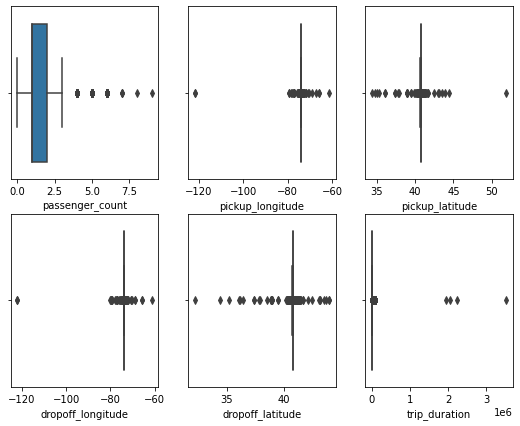

In [11]:
# check anomolies in dataset
plt.figure(figsize = (9, 7))
plt.subplot(2,3,1)
sns.boxplot(x=df.passenger_count)
plt.subplot(2,3,2)
sns.boxplot(x=df.pickup_longitude)
plt.subplot(2,3,3)
sns.boxplot(x=df.pickup_latitude)
plt.subplot(2,3,4)
sns.boxplot(x=df.dropoff_longitude)
plt.subplot(2,3,5)
sns.boxplot(x=df.dropoff_latitude)
plt.subplot(2,3,6)
sns.boxplot(x=df.trip_duration)
plt.show()

### pickup_longitude

In [12]:
#remove extreme values by simple observation
df = df[(df['pickup_longitude']<-65) & (-85<df['pickup_longitude'])]

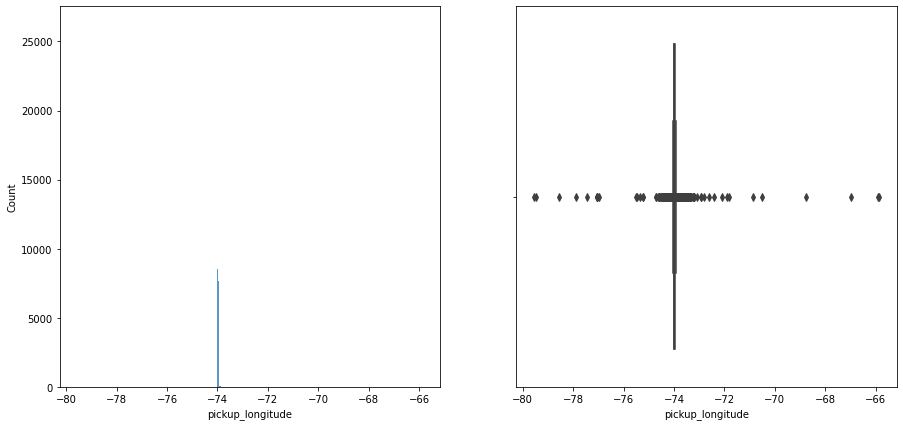

In [13]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.pickup_longitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.pickup_longitude)
# plot after removing extream values

In [14]:
# remove anamolies
df = df[(df['pickup_longitude']<-73.5) & (-74.5<df['pickup_longitude'])]

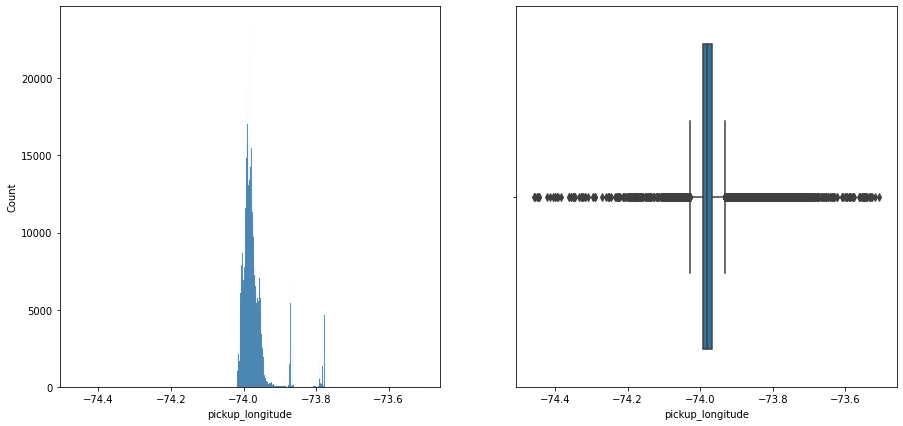

In [15]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.pickup_longitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.pickup_longitude)

### pickup_latitude

In [16]:
#remove extreme values by simple observation
df = df[(30<df['pickup_latitude']) & (df['pickup_latitude']<55)]

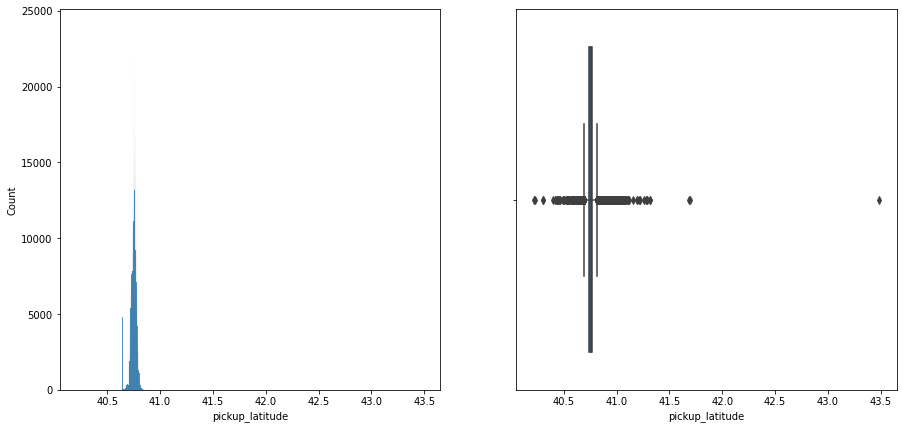

In [17]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.pickup_latitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.pickup_latitude)

In [18]:
df = df[(40.3<df['pickup_latitude']) & (df['pickup_latitude']<41.2)]

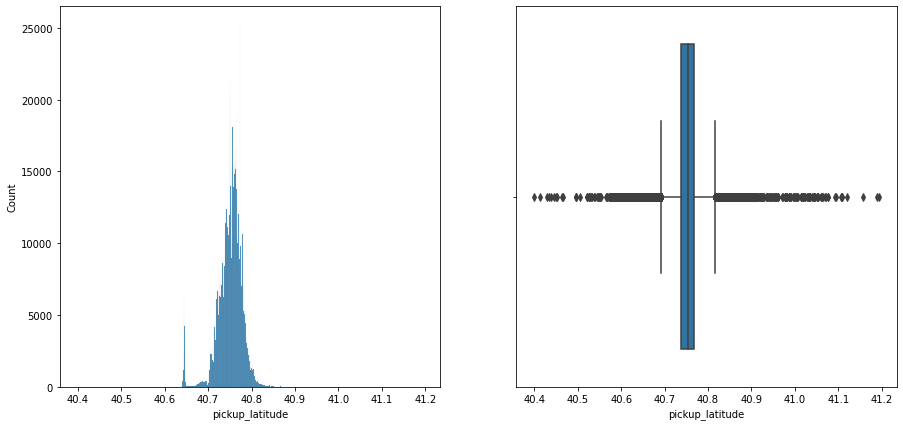

In [19]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.pickup_latitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.pickup_latitude)

### dropoff_longitude

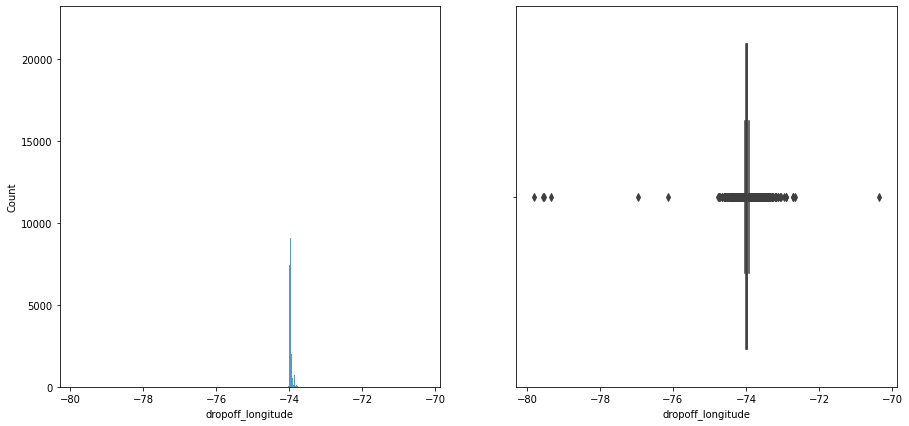

In [20]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.dropoff_longitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.dropoff_longitude)

In [21]:
df = df[(df['dropoff_longitude']<-73) & (-75<df['dropoff_longitude'])]

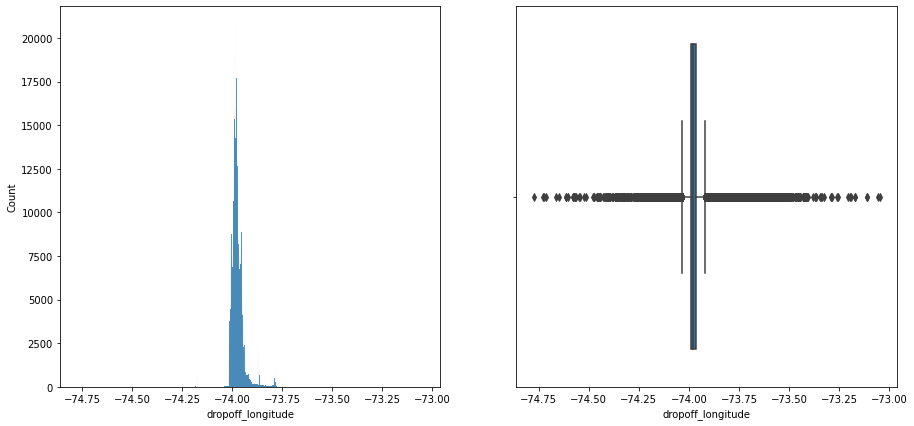

In [22]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.dropoff_longitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.dropoff_longitude)

### dropoff_latitude

In [23]:
#remove extreme values by simple observation
df = df[(30<df['dropoff_latitude']) & (df['dropoff_latitude']<55)]

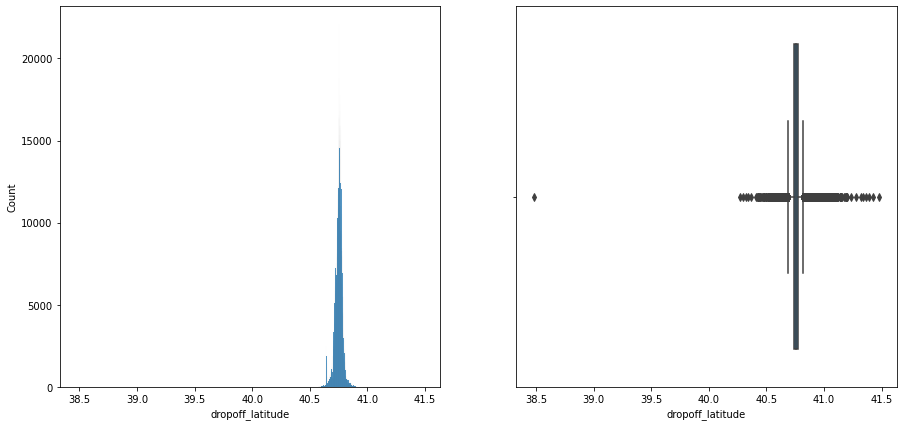

In [24]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.dropoff_latitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.dropoff_latitude)

In [25]:
df = df[(40<df['dropoff_latitude']) & (df['dropoff_latitude']<41.2)]

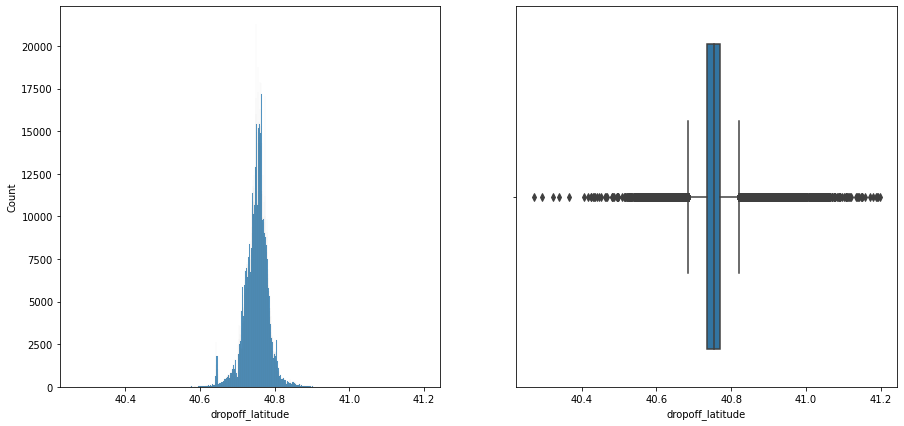

In [26]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2 , 1)
sns.histplot(x=df.dropoff_latitude)
plt.subplot(1,2 , 2)
sns.boxplot(x=df.dropoff_latitude)

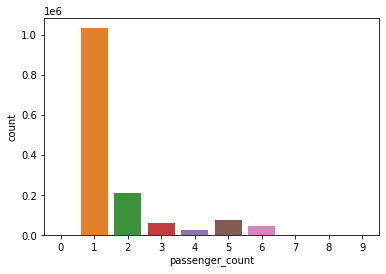

In [27]:
# plot number of passenger 
sns.countplot(x=df.passenger_count )

vehical which are carring more than 6 passengers can't be cars so we will drop  values greater than 6

In [28]:
df = df[df['passenger_count']<=6]

In [29]:
df.shape

(1458527, 10)



## Feature Enginnering

In [30]:
# Not taking 'year' as feature because all trips are from year 2016 only

df['month'] = df.pickup_datetime.apply(lambda t: t.month)
df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
df['weekend'] = df['weekday'].apply(lambda t: 1 if t in [5,6] else 0)
df['hour'] = df.pickup_datetime.apply(lambda t: t.hour) 

# abs of delta of longitude and latitude pickup-dropoff
df['delta_longitude'] = abs(df.pickup_longitude - df.dropoff_longitude)
df['delta_latitude'] = abs(df.pickup_latitude - df.dropoff_latitude)

In [31]:
# Function to find direction in degrees (Source: https://gist.github.com/jeromer/2005586)
def get_direction(lat1, lon1, lat2, lon2):
  """
  find direct in degrees
  Source: https://gist.github.com/jeromer/2005586)
  """
  lon1=lon1.to_numpy()
  lat1=lat1.to_numpy()
  lon2=lon2.to_numpy()
  lat2=lat2.to_numpy()
  diff_lon = np.deg2rad(lon2-lon1)
  x = np.sin(diff_lon) * np.cos(lat2)
  y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(diff_lon))
  initial_bearing = np.arctan2(x, y)
  direction = np.degrees (initial_bearing)

  # Now we have the initial bearing but math.atan2 return values
  # from -180° to + 180° which is not what we want for a compass bearing
  # The solution is to normalize the initial bearing as shown below

  initial_bearing = np.degrees (initial_bearing)
  direction = (initial_bearing + 360) % 360
  return direction


# Haversine Formula, distance calculation (between pick-up and drop-off coordinates) 
#

def haversine(lat1, lon1, lat2, lon2):
  """
  convert decimal degrees to radians 
  """
  lon1=np.deg2rad(lon1.to_numpy())
  lat1=np.deg2rad(lat1.to_numpy())
  lon2=np.deg2rad(lon2.to_numpy())
  lat2=np.deg2rad(lat2.to_numpy())
  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a)) 
  r = 6372.8 # Radius of earth in kilometers. Use 3956 for miles
  return np.around(c * r, decimals=2)

In [32]:
# Create columns 'direction', 'distance_km'
df['direction']   = get_direction(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])

In [33]:
# trip_duration
highest_allowed = df['trip_duration'].mean() + 3*df['trip_duration'].std()
lowest_allowed = 10
df = df[(df['trip_duration'] > lowest_allowed) & (df['trip_duration'] < highest_allowed)]
print(highest_allowed)

# distance_km
highest_allowed = df['distance_km'].mean() + 3*df['distance_km'].std()
lowest_allowed = 0.1
df = df[(df['distance_km'] > lowest_allowed) & (df['distance_km'] < highest_allowed)]


16670.680578068725


In [34]:
# df.info()

In [35]:
# columnd that are irrelevent to the regreesion problem
drop_columns =  ['vendor_id' , 'pickup_longitude' , 'pickup_latitude' , 'dropoff_longitude', 'dropoff_latitude' , 'store_and_fwd_flag' , 'pickup_datetime' , 'dropoff_datetime' ]

In [36]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,weekday,weekend,hour,delta_longitude,delta_latitude,direction,distance_km
count,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06,1.398655e+06
mean,1.533679e+00,1.662811e+00,-7.397690e+01,4.075282e+01,-7.397508e+01,4.075289e+01,7.827437e+02,3.514071e+00,3.050005e+00,2.851139e-01,1.361058e+01,1.959587e-02,1.903466e-02,2.213243e+02,2.944020e+00
std,4.988646e-01,1.313738e+00,2.857262e-02,2.440131e-02,2.847346e-02,2.935633e-02,5.524500e+02,1.680412e+00,1.951502e+00,4.514688e-01,6.400973e+00,2.409687e-02,1.823966e-02,1.191064e+02,2.603827e+00
min,1.000000e+00,0.000000e+00,-7.439355e+01,4.039825e+01,-7.439851e+01,4.041617e+01,1.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e-01
25%,1.000000e+00,1.000000e+00,-7.399207e+01,4.073853e+01,-7.399139e+01,4.073706e+01,3.930000e+02,2.000000e+00,1.000000e+00,0.000000e+00,9.000000e+00,6.195068e-03,6.847382e-03,1.788373e+02,1.230000e+00
50%,2.000000e+00,1.000000e+00,-7.398203e+01,4.075479e+01,-7.397999e+01,4.075494e+01,6.460000e+02,4.000000e+00,3.000000e+00,0.000000e+00,1.400000e+01,1.229095e-02,1.335907e-02,1.802931e+02,2.050000e+00
75%,2.000000e+00,2.000000e+00,-7.396841e+01,4.076869e+01,-7.396389e+01,4.077004e+01,1.024000e+03,5.000000e+00,5.000000e+00,1.000000e+00,1.900000e+01,2.268982e-02,2.498627e-02,3.587522e+02,3.640000e+00
max,2.000000e+00,6.000000e+00,-7.354157e+01,4.115737e+01,-7.351768e+01,4.107109e+01,1.590000e+04,6.000000e+00,6.000000e+00,1.000000e+00,2.300000e+01,1.809769e-01,1.367798e-01,3.599998e+02,1.525000e+01


In [37]:
# drop irrelevent column
df.drop(columns = drop_columns , inplace =True)

In [38]:
df.head(5)

,passenger_count,trip_duration,month,weekday,weekend,hour,delta_longitude,delta_latitude,direction,distance_km
0,1,455,3,0,0,17,0.017525,0.002335,187.443216,1.50
1,1,663,6,6,1,0,0.019066,0.007412,177.444784,1.81
2,1,2124,1,1,0,11,0.026306,0.053852,179.515450,6.39
3,1,429,4,2,0,19,0.002228,0.013252,179.833396,1.49
4,1,435,3,5,1,13,0.000130,0.010689,180.012114,1.19


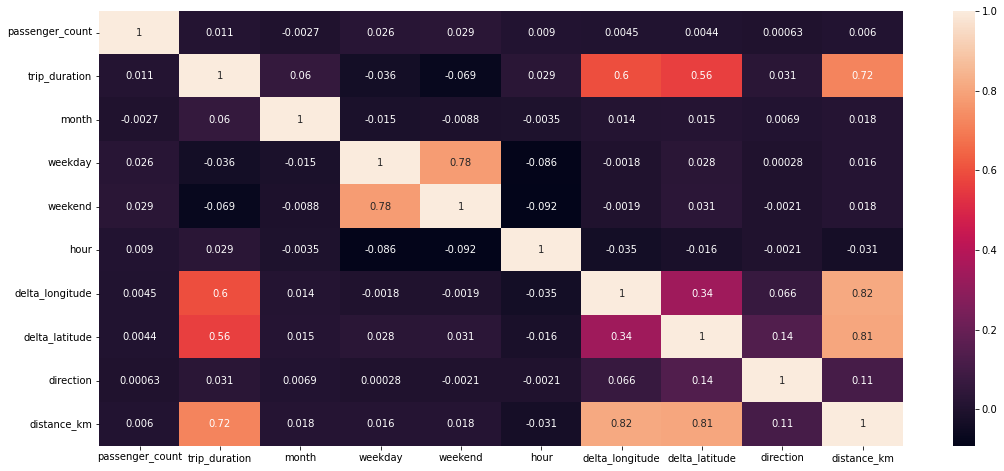

In [39]:
# correlation
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

* Drop passenger_count , month , drop weekday number 
* hour as categoriacal variable  

In [40]:
drop_columns = ['passenger_count']

In [41]:
df.drop(columns = drop_columns , inplace =True)

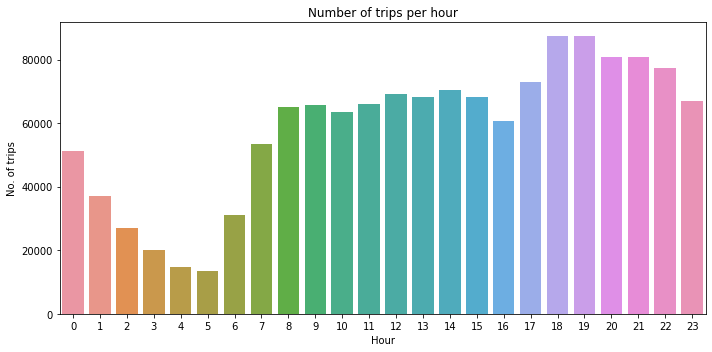

In [42]:
# Plot histogram of trip duration per hour
plt.figure(figsize = (10,5))
new_df = df.groupby('hour', as_index = False)['trip_duration'].agg(['count']).sort_values(by = 'hour', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='Hour', ylabel='No. of trips')  
plt.title('Number of trips per hour')
plt.tight_layout()
plt.show()
del new_df

In [43]:
def rush_hours(hour):
  """
  function to convert hour of to day in endconding
  """
  value = 2
  if hour in [8,9,10,11,12,13,14,15,16,17,23]:
    value =1
  elif hour in [0,1,2,3,4,5,6,7]:
    value = 0

  return value

In [44]:
df['rush_hours'] = df.hour.apply(rush_hours)

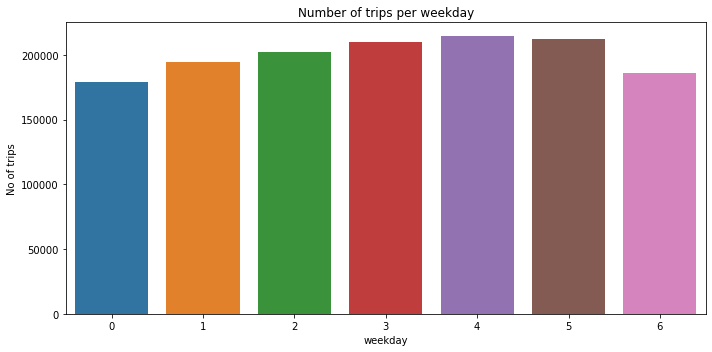

In [45]:
# Plot histogram of trips per weekday
plt.figure(figsize = (10,5))
new_df = df.groupby('weekday', as_index = False)['trip_duration'].agg(['count']).sort_values(by = 'weekday', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='weekday', ylabel='No of trips')  
plt.title('Number of trips per weekday')
plt.tight_layout()
plt.show()
del new_df

In [46]:
df.head()

,trip_duration,month,weekday,weekend,hour,delta_longitude,delta_latitude,direction,distance_km,rush_hours
0,455,3,0,0,17,0.017525,0.002335,187.443216,1.50,1
1,663,6,6,1,0,0.019066,0.007412,177.444784,1.81,0
2,2124,1,1,0,11,0.026306,0.053852,179.515450,6.39,1
3,429,4,2,0,19,0.002228,0.013252,179.833396,1.49,2
4,435,3,5,1,13,0.000130,0.010689,180.012114,1.19,1


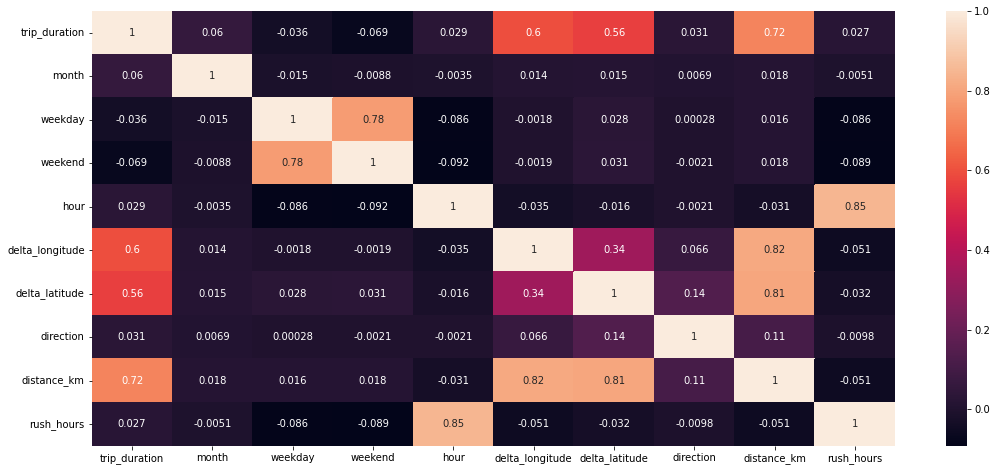

In [47]:
# correlation
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

#### Distance

In [48]:
#function to return plots for the feature
def normality(data,feature):
  """
  Function to plot and check normality of variable
  """
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  sns.distplot(data[feature],color = "b")
  plt.axvline(data[feature].mean(),color = "k",
            linestyle = "dashed",label = 'mean')
  plt.subplot(1,2,2)
  stats.probplot(data[feature],plot=pylab)
  plt.show()
  print('skewness  : ' , data[feature].skew() )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


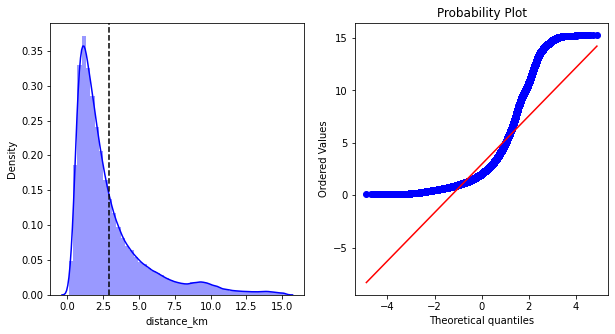

skewness  :  1.9517243542550862


In [49]:
normality(df , 'distance_km')

In [50]:
# use boxcox method to convert the skewed distribution into normal gaussian distribution 
df['distance_Boxcox'],parameters=stats.boxcox(df['distance_km'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


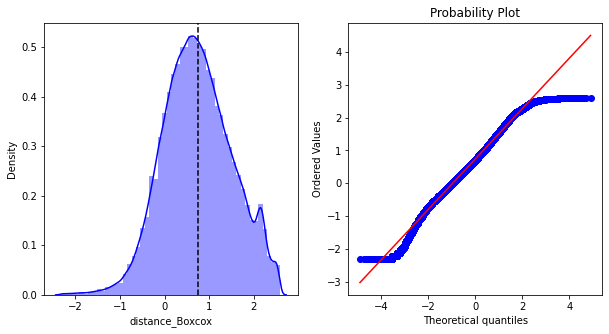

skewness  :  0.0012122340625846646


In [51]:
normality(df , 'distance_Boxcox')

### Trip duration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


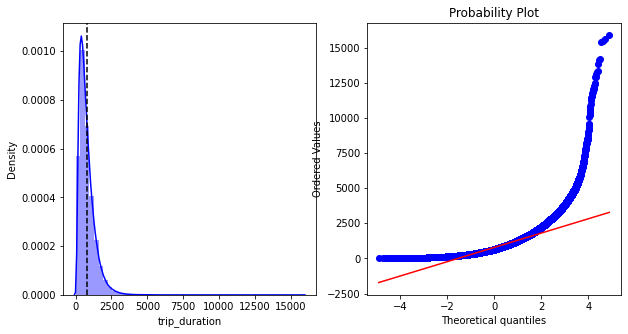

skewness  :  2.08118809062355


In [52]:
normality(df , 'trip_duration')

In [53]:
# use boxcox method to convert the skewed distribution into normal gaussian distribution 
df['duration_Boxcox'],parameters=stats.boxcox(df['trip_duration'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


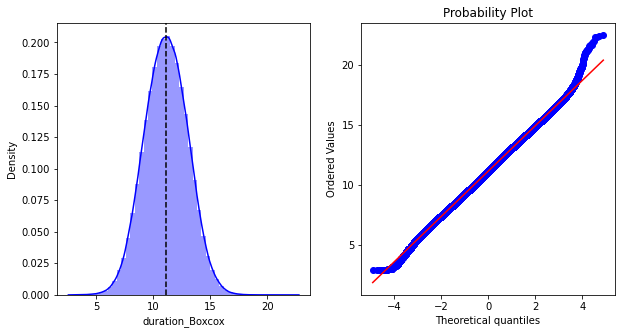

skewness  :  -0.0021837506737579933


In [54]:
normality(df , 'duration_Boxcox')

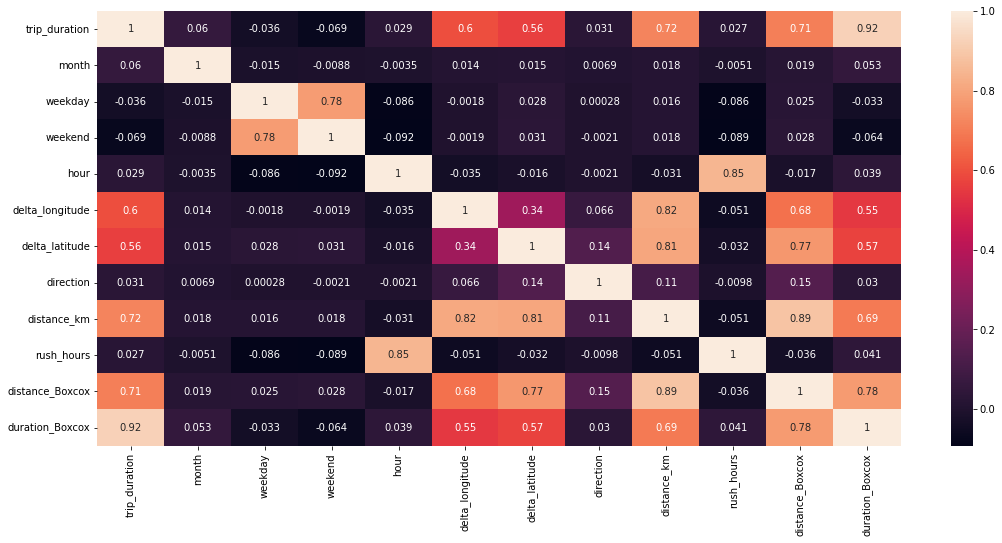

In [55]:
# correlation
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

* only numerical parameters to consider is Distance Boxcox
* rush_hour and weekend are two categorical variable
* we will perfor boxcox on trrip duration

# Modeling

In [56]:
def evaluation_metrics(y_test, y_pred):
  """
  function to evaluate the model
  """
  
  r2 = round(r2_score(y_test, y_pred), 2)
  print("R2 on test data:" ,r2)

  MSE  = round(mean_squared_error(y_test, y_pred), 2)
  print("MSE :" , MSE)

  RMSE = round(np.sqrt(MSE), 2)
  print("RMSE :" ,RMSE)

  MAE = round(mean_absolute_error(y_test, y_pred), 2) 
  print("MAE :" ,MAE)

## Linear Regression

### Train test split

In [57]:
# df.info()

In [58]:
# from correlation heatmap only columns that are relevent are
columns_to_keep = ['distance_km' , 'weekend' , 'rush_hours' , 'hour']
X = df[columns_to_keep]
y = df['trip_duration'].to_frame()

In [59]:
# spit the data into train and test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.3, random_state = 42 , stratify = X.hour) 
print(X_train.shape)
print(X_test.shape)

(979058, 4)
(419597, 4)


In [60]:
# use boxcox method to convert the skewed distribution into normal gaussian distribution 

X_train['distance_Boxcox'], dist_boxcox_param = stats.boxcox(X_train['distance_km'])
y_train['duration_Boxcox'], dura_boxcox_param = stats.boxcox(y_train['trip_duration'])

In [61]:
y_train.drop(columns = 'trip_duration' , inplace =True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


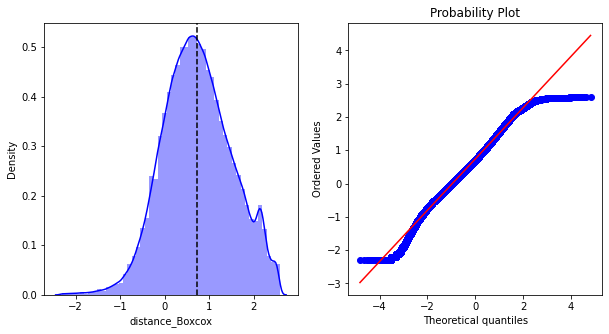

skewness  :  0.0011886027501714369


In [62]:
normality(X_train , 'distance_Boxcox')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


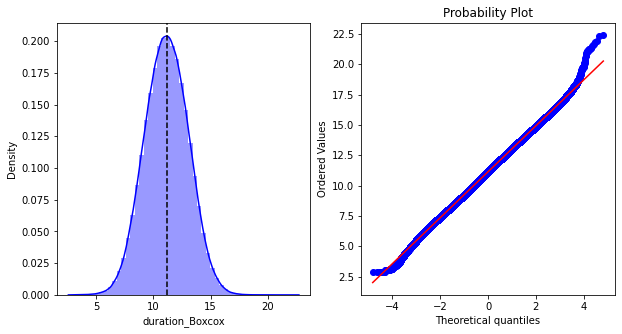

skewness  :  -0.0022636306387903205


In [63]:
normality(y_train , 'duration_Boxcox')

In [64]:
X_test['distance_Boxcox'] = stats.boxcox(X_test['distance_km'] , dist_boxcox_param)
#y_test['duration_Boxcox'] = stats.boxcox(y_test['trip_duration'] , dura_boxcox_param)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


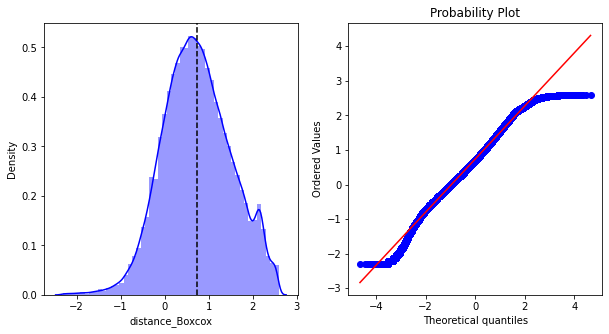

skewness  :  0.0019827705659214937


In [65]:
normality(X_test , 'distance_Boxcox')

In [66]:
X_test = X_test.drop(columns = ['distance_km' , 'hour'])
X_train = X_train.drop(columns = ['distance_km' , 'hour'])

### Unreguarized

In [67]:
# Simple linear regression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [68]:
reg.coef_

array([[-0.33749605,  0.17175617,  1.91564202]])

In [69]:
y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.55
MSE : 138919.77
RMSE : 372.72
MAE : 241.08


In [70]:
y_pred.shape

(419597, 1)

In [71]:
  y_test.shape 

(419597, 1)

### Regularized

#### Lasso regression

In [72]:
# lasso regression with grid search cv
lasso = Lasso()
parameters = {'alpha': [1e-3,1e-2,1e-1,1,5,10,20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)
y_pred = lasso_regressor.predict(X_test)

In [73]:
y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.55
MSE : 138960.83
RMSE : 372.77
MAE : 241.07


#### Ridge regression

In [74]:
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-3,1e-2,1,5,10,20]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)
y_pred = ridge_regressor.predict(X_test)

In [75]:
y_pred= scipy.special.inv_boxcox(y_pred , dura_boxcox_param)
# y_test= scipy.special.inv_boxcox(y_test , dura_boxcox_param)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.55
MSE : 138919.83
RMSE : 372.72
MAE : 241.08


## Decision Tree regression

In [76]:
columns_to_keep = ['distance_km' , 'weekend' , 'rush_hours' , 'hour' , 'delta_longitude' ,'delta_latitude']
X = df[columns_to_keep]
y = df['trip_duration']

In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1398655 entries, 0 to 1458643
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   distance_km      1398655 non-null  float64
 1   weekend          1398655 non-null  int64  
 2   rush_hours       1398655 non-null  int64  
 3   hour             1398655 non-null  int64  
 4   delta_longitude  1398655 non-null  float64
 5   delta_latitude   1398655 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 74.7 MB


In [78]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.3, random_state = 42 , stratify = X.hour) 
print(X_train.shape)
print(X_test.shape)

(979058, 6)
(419597, 6)


In [79]:
X_test = X_test.drop(columns = ['hour'])
X_train = X_train.drop(columns = ['hour'])

### Decision Tree

In [80]:
param_grid = {"min_samples_split": [2 , 4 ],
              "max_depth": [8 , 20],
              "min_samples_leaf": [4, 10 ],
              "max_leaf_nodes": [50 , 100],
              }

# dtm = DecisionTreeRegressor()
# grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5 ,n_jobs = -1 , verbose = 1)
# grid_cv_dtm.fit(X_train,y_train )


In [81]:
# with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/grid_cv_dtm' , 'wb') as f:
#   pickle.dump(grid_cv_dtm,f)

In [82]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/grid_cv_dtm' , 'rb') as f:
  grid_cv_dtm = pickle.load(f)

In [83]:
y_pred = grid_cv_dtm.predict(X_test)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.61
MSE : 120033.08
RMSE : 346.46
MAE : 229.89


In [84]:
grid_cv_dtm.best_estimator_

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=100, min_samples_leaf=4)

### Random Forest

In [85]:
# Create the parameter grid based on the results of random search
from sklearn.ensemble import RandomForestRegressor 
# param_grid = {'n_estimators': [20], "min_samples_leaf": [5 ], "max_leaf_nodes": [20, 50], 
#               "min_samples_split": [2 , 4 ] ,
#                 'max_depth': [6 , 20] }

# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 4, n_jobs = -1, verbose = 1)
# grid_search_rf.fit(X_train,y_train)

In [86]:
# grid_search_rf.best_estimator_

In [87]:
# with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/grid_search_rf' , 'wb') as f:
#   pickle.dump(grid_search_rf,f)

In [88]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/grid_search_rf' , 'rb') as f:
  grid_search_rf = pickle.load(f)

In [89]:
y_pred = grid_search_rf.predict(X_test)
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.6
MSE : 121484.88
RMSE : 348.55
MAE : 232.0


### Xgboost egressor

In [90]:
! pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
from xgboost import XGBRegressor
gb_r = XGBRegressor()

In [92]:
# gb_r.fit(X_train,y_train)
# y_pred = gb_r.predict(X_test)

In [93]:

# param_grid = {
#     'n_estimators': [400]
# }
# grid_search_xgr = GridSearchCV(estimator = gb_r, param_grid = param_grid, 
#                           cv = 3, n_jobs = 1, verbose = 2)
# grid_search_xgr.fit(X_train,y_train)

In [94]:
# with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/grid_search_xgr' , 'wb') as f:
#   pickle.dump(grid_search_xgr,f)

In [95]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/NYC Taxi Time Prediction/grid_search_xgr' , 'rb') as f:
  grid_search_xgr = pickle.load(f)

[14:08:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [96]:
y_pred = grid_search_xgr.predict(X_test)
evaluation_metrics(y_test, y_pred) 

R2 on test data: 0.62
MSE : 116356.74
RMSE : 341.11
MAE : 224.99


In [97]:
important = grid_search_xgr.best_estimator_.feature_importances_

important_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : important}

important_df = pd.DataFrame(important_dict)
important_df['Feature Importance'] = round(important_df['Feature Importance'],2)

In [98]:
important_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
important_df

,Feature,Feature Importance
0,distance_km,0.79
2,rush_hours,0.13
1,weekend,0.05
3,delta_longitude,0.02
4,delta_latitude,0.01


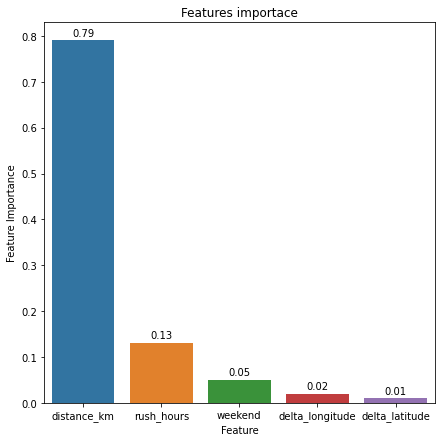

In [99]:
# plot feacture by their importance 
plt.figure(figsize=(7,7))
plt.title('Features importace')
ax = sns.barplot(x='Feature',y="Feature Importance",data=important_df[:10])
for p in ax.patches:
    ax.annotate( format(p.get_height(), '.2f' ), (p.get_x() +p.get_width()/2, p.get_height()+0.01) ,ha ='center', fontsize = 10 )

# conclusion and discussion

|**Model**  	        | RMSE|MAE|R-Squared| 
|:---:                |:---:|:---:|:--:|
|linear regression   	|372|241|0.55| 
|Lasso regresssion   	|372|241|0.55|
| Ridge regression  	|372|241|0.55|
|Decision tree        |346|230|0.61|
|Random forest        |348|232|0.6|
|Xgboost              |341|224|0.62|

* Xgboost gives best performace amonst all models
* distance is most important feature 
* after distance rush hour is second most impoortnt parameter

* Distance and time of day are not sufficient to predict the time of ride it requires a thorough understanding of traffic and for that actual path of the ride is important.
* Deep Neural Networks can improve this performance.
